In [42]:
# 📌 Importing all necessary Libraries

from google.colab import files
import zipfile
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau

import copy
import time
import os

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from PIL import Image

##Loading Dataset

In [43]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"afsheenk654","key":"759a746171702a1b22e50778376f28b8"}'}

In [44]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [45]:
!pip install -q kaggle

In [46]:
# This is the dataset ID from the Kaggle URL
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
zip_path = 'intel-image-classification.zip'
extract_path = '/content/intel_image_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted.")

✅ Dataset extracted.


In [ ]:
# Resize, convert to tensor, and normalize with ImageNet stats

# Data augmentation for training
# Adds data augmentation (flip, crop, rotate) to boost generalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(150),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet means
                         std=[0.229, 0.224, 0.225]) # ImageNet stds
])

# No augmentation for validation and test — just resizing + normalization
val_test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Paths to your dataset folders
train_path = '/content/intel_image_data/seg_train/seg_train'
test_path  = '/content/intel_image_data/seg_test/seg_test'

# Apply transforms
full_train_dataset = ImageFolder(root=train_path, transform=train_transform)
test_dataset = ImageFolder(root=test_path, transform=val_test_transform)

# Confirm classes
print(f"Classes: {full_train_dataset.classes}")

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# Define split lengths (e.g., 85% train, 15% val)
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Create random indices
indices = np.arange(len(full_train_dataset))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap in Subsets with different transforms
train_dataset = Subset(ImageFolder(train_path, transform=train_transform), train_indices)
val_dataset = Subset(ImageFolder(train_path, transform=val_test_transform), val_indices)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 11928
Validation samples: 2106


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

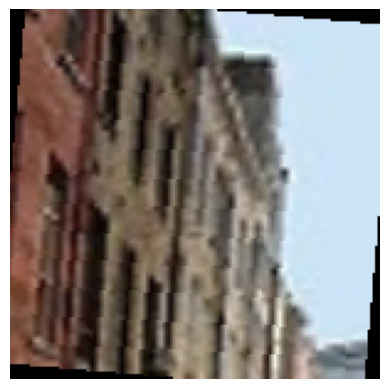

Label: street


In [ ]:
# Sample Batch:

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Unnormalize and show 4 images
def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Show the first image
imshow(images[0])
print("Label:", full_train_dataset.classes[labels[0]])


#**Classification**

## Functions


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                num_epochs=25, patience=5):

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epoch(s)...")

        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [ ]:
def plot_training_curves(train_acc, val_acc, train_loss, val_loss, results_dir):
    epochs = range(1, len(train_loss) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Train Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Val Acc')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    save_path = results_dir + '/training_curves.png'
    plt.savefig(save_path)
    plt.show()

    print(f"✅ Plot saved to: {save_path}")

In [ ]:
def evaluate_model(model, data_loader, device, class_names, results_dir):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Accuracy : {100 * acc:.2f}%")
    print(f"Precision: {100 * precision:.2f}%")
    print(f"Recall   : {100 * recall:.2f}%")
    print(f"F1 Score : {100 * f1:.2f}%")

    print("\nDetailed classification report:\n")
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    filename = results_dir + '/classification_report.txt'
    with open(filename, 'w') as f:
        f.write("Classification Report\n")
        f.write("=====================\n\n")

        f.write(f"Accuracy : {100 * acc:.2f}%\n")
        f.write(f"Precision: {100 * precision:.2f}%\n")
        f.write(f"Recall   : {100 * recall:.2f}%\n")
        f.write(f"F1 Score : {100 * f1:.2f}%\n")

        f.write("\nDetailed classification report:\n\n")
        f.write(report)

    print(f"✅ Results saved to: {filename}")

In [ ]:
def plot_confusion_matrix(model, data_loader, class_names, device, results_dir):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    save_path = results_dir + '/confusion_matrix.png'
    plt.savefig(save_path)
    plt.show()

    print(f"✅ Plot saved to: {save_path}")

In [ ]:
def show_predictions_on_test_samples(model, test_loader, class_names, device, results_dir, num_images=8):
    model.eval()
    images_shown = 0

    rows = 2
    cols = num_images // 2

    fig, axes = plt.subplots(rows, cols, figsize=(18, 9), gridspec_kw={'hspace': 0.9})
    axes = axes.flatten()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break

                image = inputs[i].cpu().numpy().transpose((1, 2, 0))
                image = (image * 0.5) + 0.5  # Unnormalize

                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                correct = (pred_label == true_label)

                ax = axes[images_shown]
                ax.imshow(image)
                ax.axis('off')

                # Title above image
                confidence = confidences[i].item() * 100
                title_color = 'green' if correct else 'red'
                ax.set_title(f"Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}",
                             color=title_color, fontsize=12)

                # Probabilities below image
                prob_text = '\n'.join([f"{class_names[j]}: {probs[i][j]*100:.1f}%"
                                       for j in range(len(class_names))])
                ax.text(0.5, -0.05, prob_text, fontsize=10, ha='center', va='top',
                        transform=ax.transAxes)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.suptitle("Predictions with Confidence on Random Test Images", fontsize=16, y=1)
    save_path = results_dir + '/test_predictions.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"✅ Plot saved to: {save_path}")

In [ ]:
def predict_custom_image(image_path, model, class_names, device, resize=150):
    # Transform for your image (must match your training transforms)
    transform = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1).cpu().numpy().flatten()

    # Top predicted class
    predicted_index = np.argmax(probabilities)
    predicted_class = class_names[predicted_index]
    predicted_confidence = probabilities[predicted_index] * 100

    # Display the image and prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({predicted_confidence:.2f}%)")
    plt.show()

    # Print all class probabilities
    print("Class probabilities:")
    for i, (cls, prob) in enumerate(zip(class_names, probabilities)):
        print(f"{cls:<10}: {prob * 100:.2f}%")

##**1. CNN Model**

In [48]:
# 📌 1: Defining CNN Model
class SceneClassifierCNN(nn.Module):
    def __init__(self):
        super(SceneClassifierCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 18 * 18, 256)  # Based on 150x150 input resized down by pooling
        self.fc2 = nn.Linear(256, 6)  # 6 scene classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (3,150,150) → (32,75,75)
        x = self.pool(F.relu(self.conv2(x)))  # (32,75,75) → (64,37,37)
        x = self.pool(F.relu(self.conv3(x)))  # (64,37,37) → (128,18,18)
        x = self.dropout(x)
        x = x.view(-1, 128 * 18 * 18)         # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# 📌 2: Initializing Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SceneClassifierCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [ ]:
# 📌 3: Creating Results Directory to Store CNN Results
results_dir = "results/CNN"
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# 📌 4: Train + Validate Model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=25, patience=5
)

torch.save(model.state_dict(), 'results/CNN/scene_classifier_cnn.pth')
print("✅ Model saved.")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/25
Train Loss: 1.1624, Acc: 0.5409 | Val Loss: 0.7834, Acc: 0.6947

Epoch 2/25
Train Loss: 0.9066, Acc: 0.6656 | Val Loss: 0.6637, Acc: 0.7512

Epoch 3/25
Train Loss: 0.8046, Acc: 0.7060 | Val Loss: 0.5769, Acc: 0.7901

Epoch 4/25
Train Loss: 0.7580, Acc: 0.7212 | Val Loss: 0.5274, Acc: 0.8105

Epoch 5/25
Train Loss: 0.7227, Acc: 0.7341 | Val Loss: 0.5349, Acc: 0.8120
⏳ No improvement for 1 epoch(s)...

Epoch 6/25
Train Loss: 0.6997, Acc: 0.7408 | Val Loss: 0.5658, Acc: 0.7920
⏳ No improvement for 2 epoch(s)...

Epoch 7/25
Train Loss: 0.6806, Acc: 0.7492 | Val Loss: 0.4751, Acc: 0.8376

Epoch 8/25
Train Loss: 0.6575, Acc: 0.7574 | Val Loss: 0.4398, Acc: 0.8443

Epoch 9/25
Train Loss: 0.6322, Acc: 0.7637 | Val Loss: 0.4656, Acc: 0.8281
⏳ No improvement for 1 epoch(s)...

Epoch 10/25
Train Loss: 0.6336, Acc: 0.7684 | Val Loss: 0.4299, Acc: 0.8561

Epoch 11/25
Train Loss: 0.6035, Acc: 0.7744 | Val Loss: 0.4509, Acc: 0.8405
⏳ No improvement for 1 epoch(s)...

Epoch 12/25
Train Los

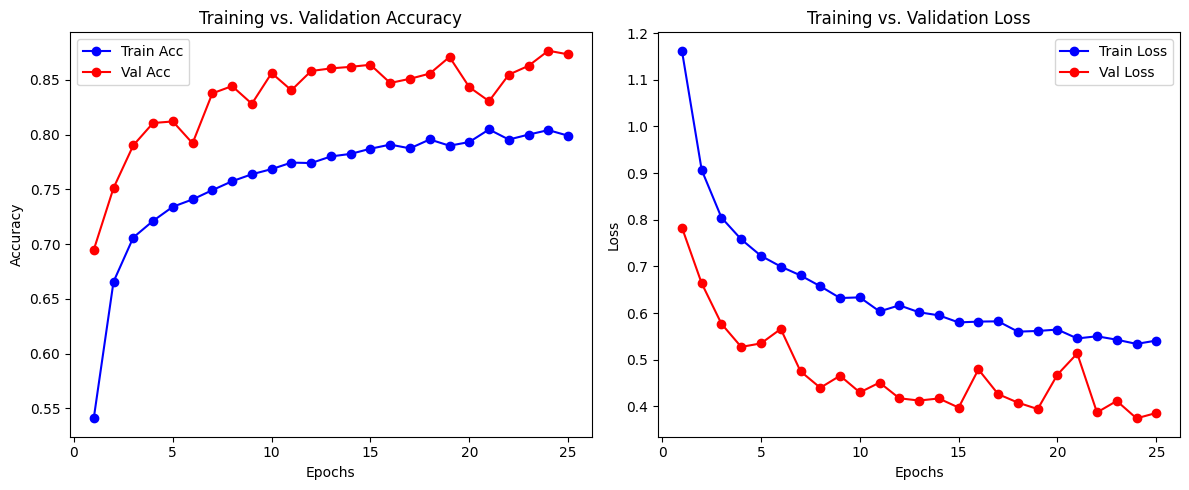

✅ Plot saved to: results/CNN/training_curves.png


In [ ]:
# 📌 5: Plotting Training vs. Validation Accuracy Curves
plot_training_curves(train_acc_history, val_acc_history, train_loss_history, val_loss_history, results_dir)

In [ ]:
# 📌 6: Calculating Evaluation Metrics (Accuracy, Precision, Recall, and F1 Score)
model.load_state_dict(torch.load('results/CNN/scene_classifier_cnn.pth'))
model.eval()  # Set to evaluation mode

class_names = full_train_dataset.classes  # ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
evaluate_model(model, test_loader, device, class_names, results_dir)

Accuracy : 87.37%
Precision: 87.51%
Recall   : 87.62%
F1 Score : 87.50%

Detailed classification report:

              precision    recall  f1-score   support

   buildings       0.81      0.88      0.84       437
      forest       0.99      0.97      0.98       474
     glacier       0.88      0.80      0.84       553
    mountain       0.81      0.82      0.82       525
         sea       0.87      0.92      0.90       510
      street       0.89      0.87      0.88       501

    accuracy                           0.87      3000
   macro avg       0.88      0.88      0.87      3000
weighted avg       0.87      0.87      0.87      3000

✅ Results saved to: results/CNN/classification_report.txt


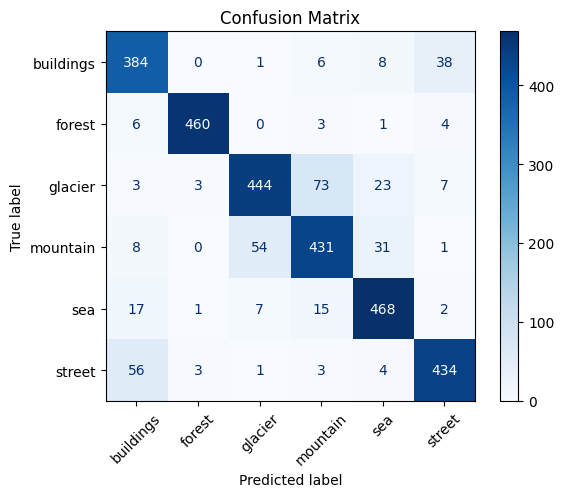

✅ Plot saved to: results/CNN/confusion_matrix.png


In [ ]:
# 📌 7: Confusion Matrix
class_names = full_train_dataset.classes  # ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
plot_confusion_matrix(model, test_loader, class_names, device, results_dir)

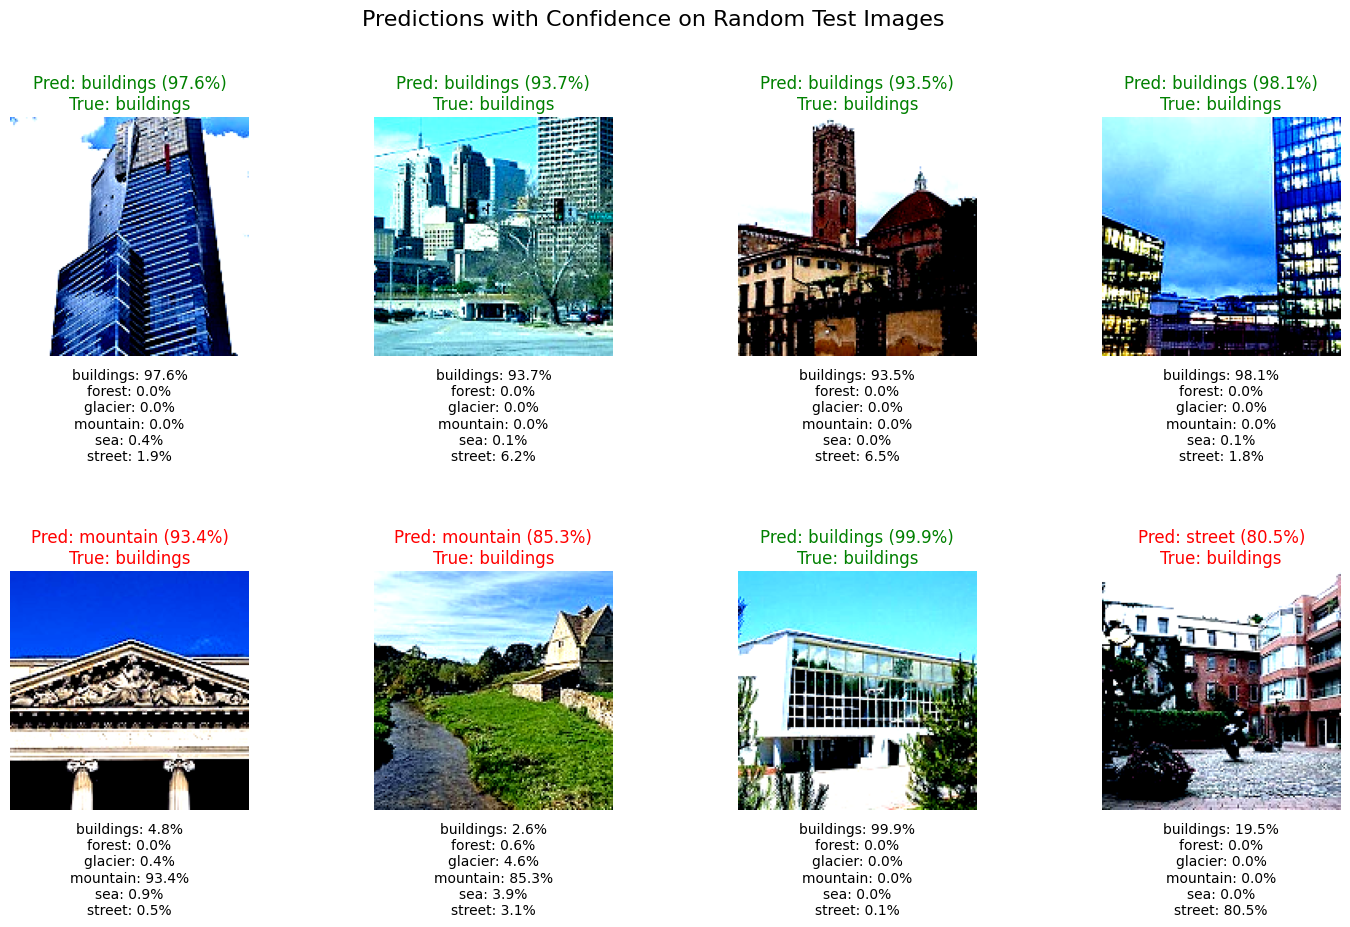

✅ Plot saved to: results/CNN/test_predictions.png


In [ ]:
# 📌 8: Visualizing Predictions on Random Test Images
show_predictions_on_test_samples(model, test_loader, class_names, device, results_dir, num_images=8)

Saving image.jpg to image.jpg


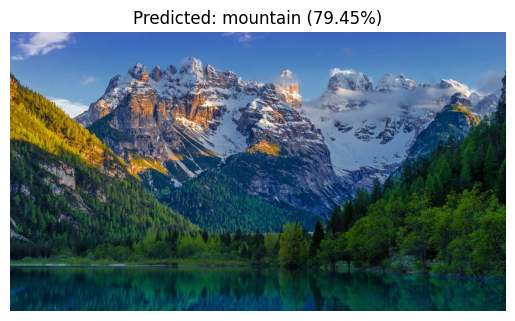

Class probabilities:
buildings : 0.23%
forest    : 0.56%
glacier   : 18.77%
mountain  : 79.45%
sea       : 0.94%
street    : 0.05%


In [ ]:
# 📌 9: Prediction on New Images
uploaded = files.upload()
predict_custom_image("image.jpg", model, class_names, device)

In [ ]:
# 📌 10: Download Results
files.download('results/CNN/scene_classifier_cnn.pth')
files.download("results/CNN/classification_report.txt")
files.download("results/CNN/confusion_matrix.png")
files.download("results/CNN/training_curves.png")
files.download("results/CNN/test_predictions.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **2. Vision Transformer Model**

In [ ]:
# 📌 1: Defining Vision Transformer Model
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, D // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        return self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, qkv_bias, attn_drop, drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=6,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.,
                 qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias, drop_rate, attn_drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train samples: 11928
Validation samples: 2106


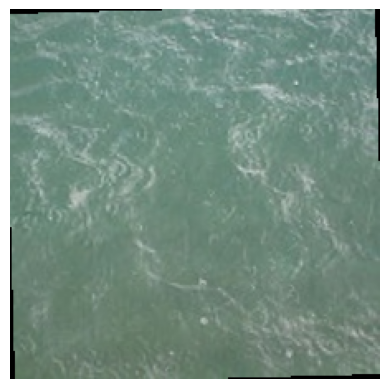

Label: sea


In [ ]:
# 📌 2: Update Pre-processing - ViTs expect 224×224 images (not 150×150)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths to your dataset folders
train_path = '/content/intel_image_data/seg_train/seg_train'
test_path  = '/content/intel_image_data/seg_test/seg_test'

# Apply transforms
full_train_dataset = ImageFolder(root=train_path, transform=train_transform)
test_dataset = ImageFolder(root=test_path, transform=val_test_transform)

# Confirm classes
print(f"Classes: {full_train_dataset.classes}")

# Define split lengths (e.g., 85% train, 15% val)
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Create random indices
indices = np.arange(len(full_train_dataset))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap in Subsets with different transforms
train_dataset = Subset(ImageFolder(train_path, transform=train_transform), train_indices)
val_dataset = Subset(ImageFolder(train_path, transform=val_test_transform), val_indices)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Sample Batch:

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Unnormalize and show 4 images
def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Show the first image
imshow(images[0])
print("Label:", full_train_dataset.classes[labels[0]])

In [ ]:
# 📌 3: Initializing Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

vit_model = VisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=6,  # from dataset
    embed_dim=256,  # or 768, based on resources
    depth=6,        # can reduce for faster training
    num_heads=8,
    mlp_ratio=4.0,
    qkv_bias=True,
    drop_rate=0.1,
    attn_drop_rate=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

Using device: cuda


In [ ]:
# 📌 4: Creating Results Directory to Store ViT Results
results_dir = "results/ViT"
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# 📌 5: Train + Validate Model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    vit_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=25, patience=5
)

torch.save(vit_model.state_dict(), 'results/ViT/scene_classifier_vit.pth')
print("✅ Model saved.")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/25
Train Loss: 1.1629, Acc: 0.5265 | Val Loss: 0.9669, Acc: 0.6035

Epoch 2/25
Train Loss: 0.9391, Acc: 0.6275 | Val Loss: 0.9615, Acc: 0.6263

Epoch 3/25
Train Loss: 0.8613, Acc: 0.6648 | Val Loss: 0.8383, Acc: 0.6790

Epoch 4/25
Train Loss: 0.7843, Acc: 0.6999 | Val Loss: 0.7456, Acc: 0.7094

Epoch 5/25
Train Loss: 0.7306, Acc: 0.7185 | Val Loss: 0.7208, Acc: 0.7293

Epoch 6/25
Train Loss: 0.6951, Acc: 0.7340 | Val Loss: 0.6754, Acc: 0.7417

Epoch 7/25
Train Loss: 0.6585, Acc: 0.7503 | Val Loss: 0.6430, Acc: 0.7607

Epoch 8/25
Train Loss: 0.6324, Acc: 0.7619 | Val Loss: 0.6613, Acc: 0.7498
⏳ No improvement for 1 epoch(s)...

Epoch 9/25
Train Loss: 0.5973, Acc: 0.7760 | Val Loss: 0.6307, Acc: 0.7555

Epoch 10/25
Train Loss: 0.5806, Acc: 0.7836 | Val Loss: 0.6239, Acc: 0.7726

Epoch 11/25
Train Loss: 0.5682, Acc: 0.7883 | Val Loss: 0.6637, Acc: 0.7550
⏳ No improvement for 1 epoch(s)...

Epoch 12/25
Train Loss: 0.5497, Acc: 0.7907 | Val Loss: 0.5829, Acc: 0.7868

Epoch 13/25
Tr

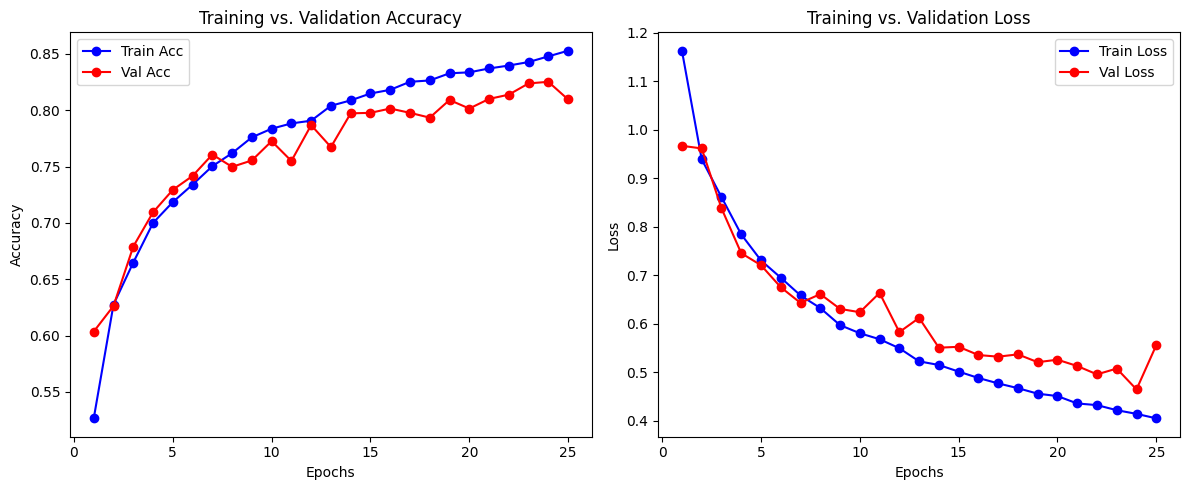

✅ Plot saved to: results/ViT/training_curves.png


In [ ]:
# 📌 6: Plotting Training vs. Validation Accuracy Curves
plot_training_curves(train_acc_history, val_acc_history, train_loss_history, val_loss_history, results_dir)

In [ ]:
# 📌 7: Calculating Evaluation Metrics (Accuracy, Precision, Recall, and F1 Score)
vit_model.load_state_dict(torch.load('results/ViT/scene_classifier_vit.pth'))
vit_model.eval()  # Set to evaluation mode

class_names = full_train_dataset.classes  # ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
evaluate_model(vit_model, test_loader, device, class_names, results_dir)

Accuracy : 83.60%
Precision: 83.66%
Recall   : 83.63%
F1 Score : 83.63%

Detailed classification report:

              precision    recall  f1-score   support

   buildings       0.78      0.78      0.78       437
      forest       0.95      0.96      0.95       474
     glacier       0.80      0.83      0.81       553
    mountain       0.83      0.80      0.81       525
         sea       0.84      0.84      0.84       510
      street       0.84      0.80      0.82       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000

✅ Results saved to: results/ViT/classification_report.txt


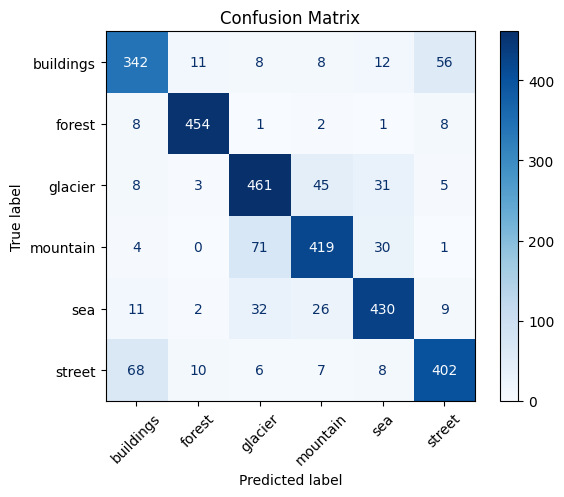

✅ Plot saved to: results/ViT/confusion_matrix.png


In [ ]:
# 📌 8: Confusion Matrix
plot_confusion_matrix(vit_model, test_loader, class_names, device, results_dir)

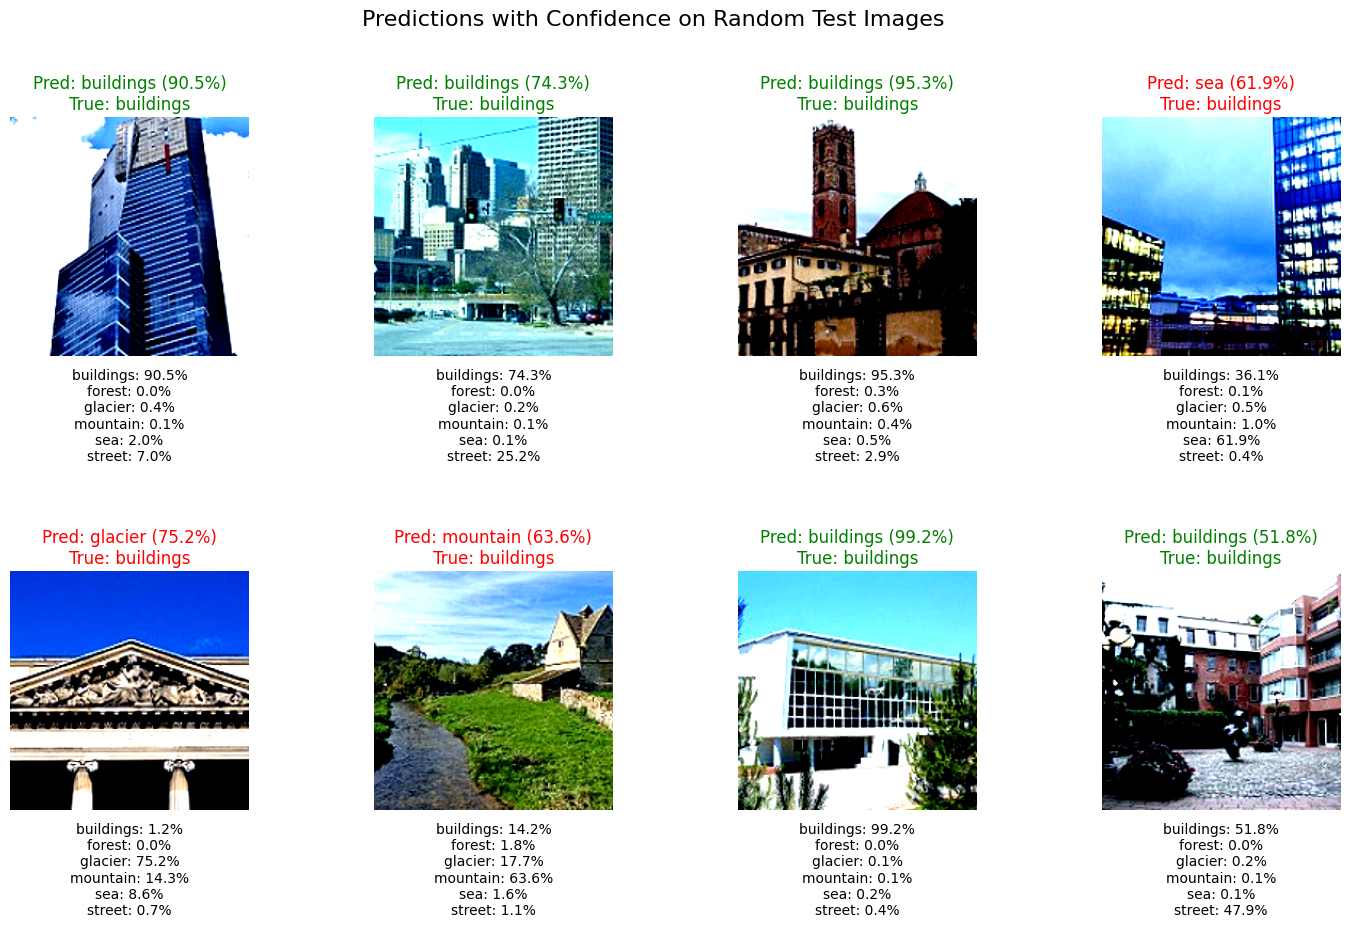

✅ Plot saved to: results/ViT/test_predictions.png


In [ ]:
# 📌 9: Visualizing Predictions on Random Test Images
show_predictions_on_test_samples(vit_model, test_loader, class_names, device, results_dir, num_images=8)

Saving image.jpg to image.jpg


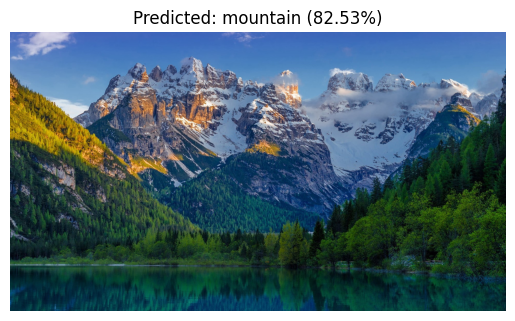

Class probabilities:
buildings : 0.07%
forest    : 4.57%
glacier   : 11.97%
mountain  : 82.53%
sea       : 0.66%
street    : 0.20%


In [ ]:
# 📌 10: Prediction on New Images
uploaded = files.upload()
predict_custom_image("image.jpg", vit_model, class_names, device, 224)

In [ ]:
# 📌 11: Download Results
files.download('results/ViT/scene_classifier_vit.pth')
files.download("results/ViT/classification_report.txt")
files.download("results/ViT/confusion_matrix.png")
files.download("results/ViT/training_curves.png")
files.download("results/ViT/test_predictions.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **3. MLP-Mixer Model**

In [ ]:
# 📌 1: Defining MLP-Mixer Model
class MLPBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(MLPBlock, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

class MixerBlock(nn.Module):
    def __init__(self, num_patches, hidden_dim, tokens_mlp_dim, channels_mlp_dim):
        super(MixerBlock, self).__init__()

        # Token-mixing MLP
        self.token_norm = nn.LayerNorm(hidden_dim)
        self.token_mlp = nn.Sequential(
            nn.Linear(num_patches, tokens_mlp_dim),
            nn.GELU(),
            nn.Linear(tokens_mlp_dim, num_patches)
        )

        # Channel-mixing MLP
        self.channel_norm = nn.LayerNorm(hidden_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(hidden_dim, channels_mlp_dim),
            nn.GELU(),
            nn.Linear(channels_mlp_dim, hidden_dim)
        )

    def forward(self, x):  # x: [B, num_patches, hidden_dim]
        y = self.token_norm(x)
        y = y.transpose(1, 2)                 # -> [B, hidden_dim, num_patches]
        y = self.token_mlp(y)                 # token mixing
        y = y.transpose(1, 2)                 # -> [B, num_patches, hidden_dim]
        x = x + y                             # Residual connection

        z = self.channel_norm(x)              # LayerNorm on [*, hidden_dim]
        z = self.channel_mlp(z)               # channel mixing
        x = x + z                             # Residual connection
        return x

class MLPMixer(nn.Module):
    def __init__(self, in_channels=3, image_size=224, patch_size=16, num_classes=6,
                 num_blocks=8, hidden_dim=512, token_dim=256, channel_dim=2048):
        super(MLPMixer, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size

        self.patch_embedding = nn.Sequential(
            nn.Unfold(kernel_size=patch_size, stride=patch_size),
            nn.Linear(patch_dim, hidden_dim)
        )

        self.mixer_blocks = nn.Sequential(*[
            MixerBlock(num_patches, hidden_dim, token_dim, channel_dim)
            for _ in range(num_blocks)
        ])

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.mlp_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding[0](x).transpose(1, 2)
        x = self.patch_embedding[1](x)
        x = self.mixer_blocks(x)
        x = self.layer_norm(x)
        x = x.mean(dim=1)
        return self.mlp_head(x)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train samples: 11928
Validation samples: 2106


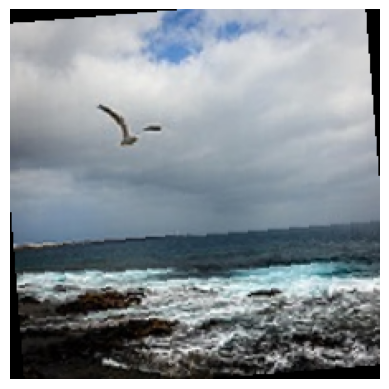

Label: sea


In [ ]:
# 📌 2: Update Pre-processing - MLP-Mixer expect 224×224 images (not 150×150)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths to your dataset folders
train_path = '/content/intel_image_data/seg_train/seg_train'
test_path  = '/content/intel_image_data/seg_test/seg_test'

# Apply transforms
full_train_dataset = ImageFolder(root=train_path, transform=train_transform)
test_dataset = ImageFolder(root=test_path, transform=val_test_transform)

# Confirm classes
print(f"Classes: {full_train_dataset.classes}")

# Define split lengths (e.g., 85% train, 15% val)
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Create random indices
indices = np.arange(len(full_train_dataset))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap in Subsets with different transforms
train_dataset = Subset(ImageFolder(train_path, transform=train_transform), train_indices)
val_dataset = Subset(ImageFolder(train_path, transform=val_test_transform), val_indices)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Sample Batch:

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Unnormalize and show 4 images
def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Show the first image
imshow(images[0])
print("Label:", full_train_dataset.classes[labels[0]])

In [ ]:
# 📌 3: Initializing Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

mlpm_model = MLPMixer(
        image_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=6,  # 6 classes in our dataset
        num_blocks=8,
        hidden_dim=512,
        token_dim=256,
        channel_dim=2048
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mlpm_model.parameters(), lr=1e-4, weight_decay=1e-5)

Using device: cuda


In [ ]:
# 📌 4: Creating Results Directory to Store ViT Results
results_dir = "results/MLPM"
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# 📌 5: Train + Validate Model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    mlpm_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=25, patience=5
)


Epoch 1/25
Train Loss: 1.0428, Acc: 0.5890 | Val Loss: 1.0124, Acc: 0.5945

Epoch 2/25
Train Loss: 0.8146, Acc: 0.6924 | Val Loss: 0.7316, Acc: 0.7365

Epoch 3/25
Train Loss: 0.6927, Acc: 0.7457 | Val Loss: 0.6552, Acc: 0.7621

Epoch 4/25
Train Loss: 0.6203, Acc: 0.7762 | Val Loss: 0.5626, Acc: 0.8034

Epoch 5/25
Train Loss: 0.5612, Acc: 0.7966 | Val Loss: 0.6222, Acc: 0.7754
⏳ No improvement for 1 epoch(s)...

Epoch 6/25
Train Loss: 0.5289, Acc: 0.8076 | Val Loss: 0.5668, Acc: 0.8025
⏳ No improvement for 2 epoch(s)...

Epoch 7/25
Train Loss: 0.4965, Acc: 0.8198 | Val Loss: 0.5049, Acc: 0.8243

Epoch 8/25
Train Loss: 0.4639, Acc: 0.8305 | Val Loss: 0.5161, Acc: 0.8186
⏳ No improvement for 1 epoch(s)...

Epoch 9/25
Train Loss: 0.4327, Acc: 0.8440 | Val Loss: 0.5486, Acc: 0.7991
⏳ No improvement for 2 epoch(s)...

Epoch 10/25
Train Loss: 0.4143, Acc: 0.8471 | Val Loss: 0.4581, Acc: 0.8324

Epoch 11/25
Train Loss: 0.3775, Acc: 0.8647 | Val Loss: 0.4888, Acc: 0.8409
⏳ No improvement for 1

NameError: name 'vit_model' is not defined

In [ ]:
torch.save(mlpm_model.state_dict(), 'results/MLPM/scene_classifier_mlpm.pth')
print("✅ Model saved.")

✅ Model saved.


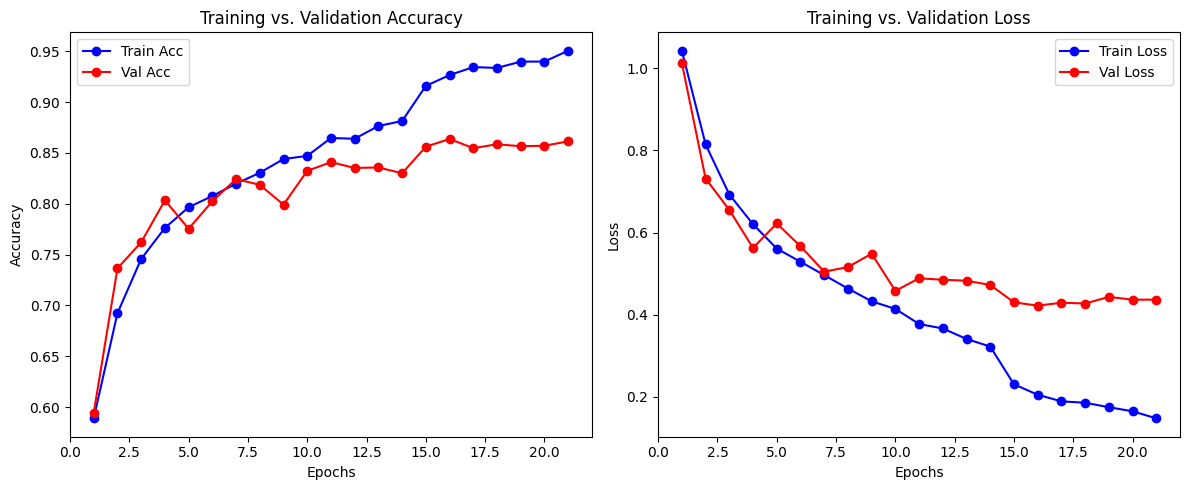

✅ Plot saved to: results/MLPM/training_curves.png


In [ ]:
# 📌 6: Plotting Training vs. Validation Accuracy Curves
plot_training_curves(train_acc_history, val_acc_history, train_loss_history, val_loss_history, results_dir)

In [ ]:
# 📌 7: Calculating Evaluation Metrics (Accuracy, Precision, Recall, and F1 Score)
mlpm_model.load_state_dict(torch.load('results/MLPM/scene_classifier_mlpm.pth'))
mlpm_model.eval()  # Set to evaluation mode

class_names = full_train_dataset.classes  # ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
evaluate_model(mlpm_model, test_loader, device, class_names, results_dir)

Accuracy : 85.97%
Precision: 86.12%
Recall   : 86.06%
F1 Score : 86.06%

Detailed classification report:

              precision    recall  f1-score   support

   buildings       0.84      0.84      0.84       437
      forest       0.94      0.91      0.92       474
     glacier       0.84      0.82      0.83       553
    mountain       0.84      0.84      0.84       525
         sea       0.88      0.86      0.87       510
      street       0.83      0.89      0.86       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000

✅ Results saved to: results/MLPM/classification_report.txt


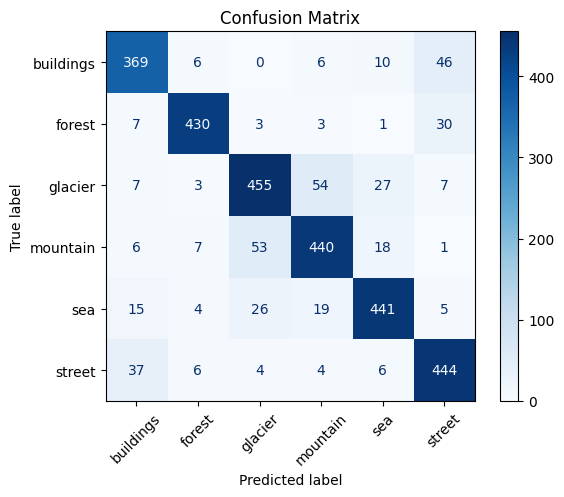

✅ Plot saved to: results/MLPM/confusion_matrix.png


In [ ]:
# 📌 8: Confusion Matrix
plot_confusion_matrix(mlpm_model, test_loader, class_names, device, results_dir)

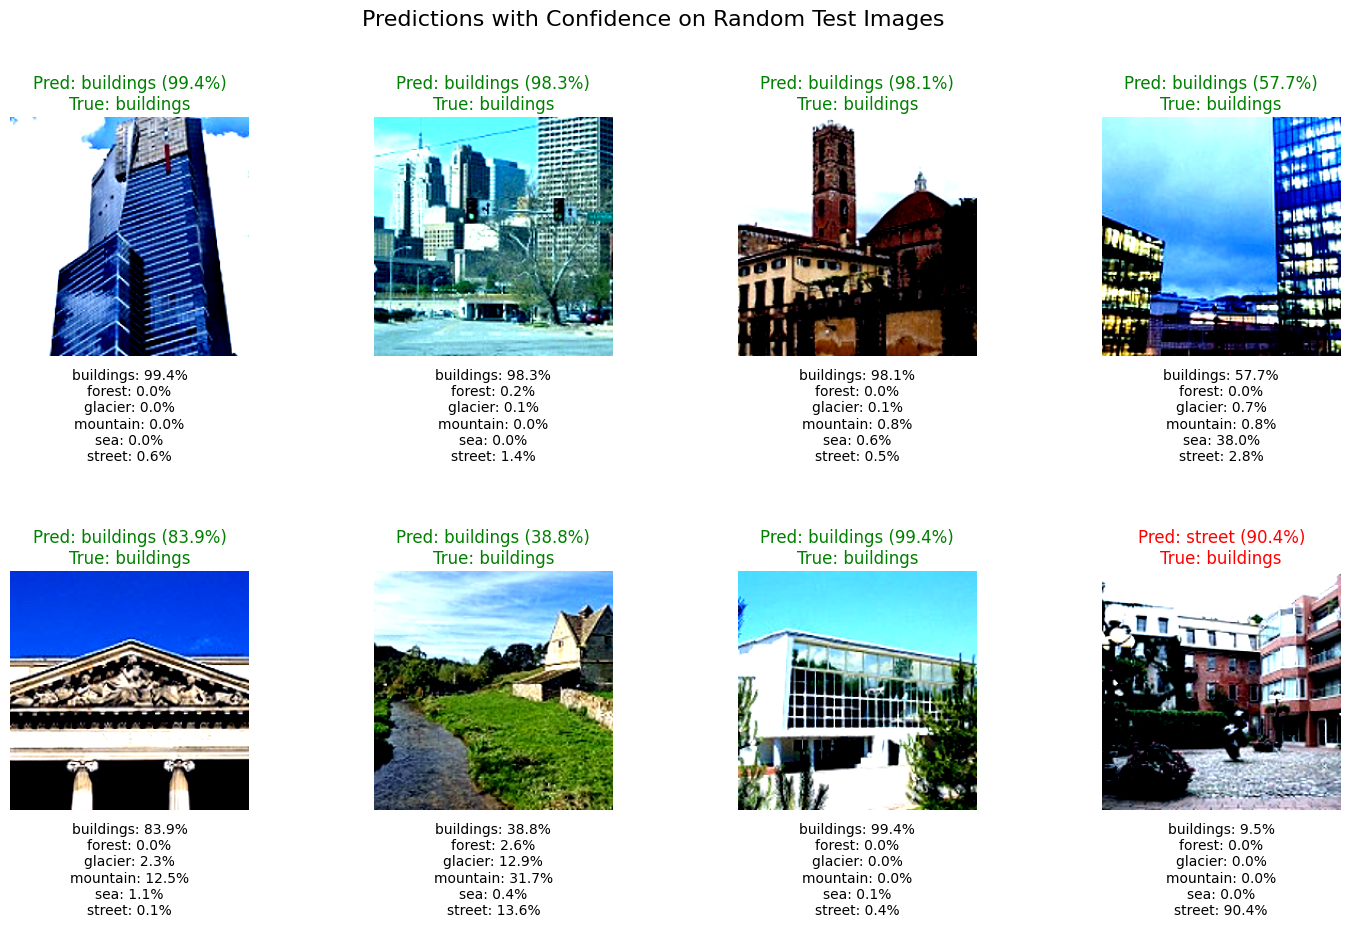

✅ Plot saved to: results/MLPM/test_predictions.png


In [ ]:
# 📌 9: Visualizing Predictions on Random Test Images
show_predictions_on_test_samples(mlpm_model, test_loader, class_names, device, results_dir, num_images=8)

Saving image.jpg to image.jpg


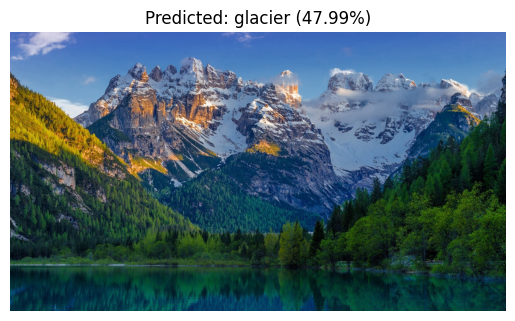

Class probabilities:
buildings : 0.43%
forest    : 23.35%
glacier   : 47.99%
mountain  : 22.47%
sea       : 1.78%
street    : 3.98%


In [ ]:
# 📌 10: Prediction on New Images
uploaded = files.upload()
predict_custom_image("image.jpg", mlpm_model, class_names, device, 224)

In [ ]:
# 📌 11: Download Results
files.download('results/MLPM/scene_classifier_mlpm.pth')
files.download("results/MLPM/classification_report.txt")
files.download("results/MLPM/confusion_matrix.png")
files.download("results/MLPM/training_curves.png")
files.download("results/MLPM/test_predictions.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Regression**

##Functions

In [49]:
def evaluate_regression(xgb_model, data_loader, cnn_model, device, results_dir):
    all_preds = []
    all_labels = []

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Extract features using CNN
        with torch.no_grad():
            outputs = cnn_model(inputs)  # Use your CNN model to extract features
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Get class probabilities

        # Use the extracted features for prediction with XGBoost
        preds = xgb_model.predict(probs)  # Predict using XGBoost

        all_preds.extend(preds)
        for label in labels.cpu().numpy():
          class_name = class_names[label]
          true_score = impact_scores_map[class_name]
          all_labels.append(true_score)

    # Metrics
    rmse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    # Save to file
    report_path = os.path.join(results_dir, 'regression_report.txt')
    with open(report_path, 'w') as f:
        f.write("Regression Evaluation Report\n")
        f.write("============================\n\n")
        f.write(f"RMSE: {rmse:.4f}\n")
        f.write(f"MAE : {mae:.4f}\n")
        f.write(f"R²  : {r2:.4f}\n")

    print(f"✅ Regression report saved to: {report_path}")

In [50]:
def plot_regression_predictions(y_true, y_pred, results_dir):
    plt.figure(figsize=(7, 7))
    plt.scatter(y_true, y_pred, alpha=0.6, color='blue', edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.title("Actual vs. Predicted Impact Scores")
    plt.xlabel("True Score")
    plt.ylabel("Predicted Score")
    plt.grid(True)

    save_path = os.path.join(results_dir, 'regression_scatter_plot.png')
    plt.savefig(save_path)
    plt.show()
    print(f"✅ Plot saved to: {save_path}")

In [51]:
def show_regression_predictions(xgb_model, test_loader, cnn_model, device, results_dir,
                                 class_names, impact_scores_map, num_images=8):
    cnn_model.eval()
    xgb_model.get_booster()  # To ensure model is loaded correctly

    images_shown = 0
    rows = 2
    cols = num_images // 2

    fig, axes = plt.subplots(rows, cols, figsize=(18, 9))
    axes = axes.flatten()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)

            # Step 1: Extract CNN class probabilities as features
            logits = cnn_model(inputs)
            probs = torch.softmax(logits, dim=1).cpu().numpy()

            # Step 2: Predict with XGBoost
            preds = xgb_model.predict(probs)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break

                # Prepare image for display
                image = inputs[i].cpu().numpy().transpose((1, 2, 0))
                image = (image * 0.5) + 0.5  # Unnormalize if normalized earlier

                # True score from class index
                class_idx = labels[i].item()
                class_name = class_names[class_idx]
                true_score = impact_scores_map[class_name]

                pred_score = preds[i]

                ax = axes[images_shown]
                ax.imshow(image)
                ax.axis('off')
                ax.set_title(f"Pred: {pred_score:.2f}\nTrue: {true_score:.2f}",
                             color='green' if abs(pred_score - true_score) < 0.1 else 'red')

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.suptitle("Environmental Impact Score Predictions", fontsize=16)
    save_path = os.path.join(results_dir, 'regression_image_predictions.png')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()

    print(f"✅ Image predictions saved to: {save_path}")

##**XGBoost**

In [52]:
# 📌 1: Preprocessing Data
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset_path = '/content/intel_image_data/seg_train/seg_train'  # update if needed
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)

dataloader = DataLoader(full_dataset, batch_size=32, shuffle=True)
class_names = full_dataset.classes

In [ ]:
# 📌 1: CNN Model
class SceneClassifierCNN(nn.Module):
    def __init__(self):
        super(SceneClassifierCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 18 * 18, 256)  # Based on 150x150 input resized down by pooling
        self.fc2 = nn.Linear(256, 6)  # 6 scene classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (3,150,150) → (32,75,75)
        x = self.pool(F.relu(self.conv2(x)))  # (32,75,75) → (64,37,37)
        x = self.pool(F.relu(self.conv3(x)))  # (64,37,37) → (128,18,18)
        x = self.dropout(x)
        x = x.view(-1, 128 * 18 * 18)         # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [56]:
# 📌 2: Loading CNN Model
# files.upload()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SceneClassifierCNN().to(device)
cnn_model.load_state_dict(torch.load('scene_classifier_cnn.pth', map_location=device))
cnn_model.eval()

SceneClassifierCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

In [57]:
# 📌 3: Generate Data for XGBoost

# Assign environmental impact scores to each class
# (e.g., 0 = least impact like forests, 1 = highest like buildings)
impact_scores_map = {
    'buildings': 0.9,
    'forest': 0.1,
    'glacier': 0.05,
    'mountain': 0.2,
    'sea': 0.3,
    'street': 0.85
}

features, targets = [], []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        outputs = cnn_model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        features.extend(probs)  # input: class probabilities
        for label in labels:
            cls_name = class_names[label]
            score = impact_scores_map[cls_name]
            targets.append(score)

In [58]:
# 📌 3: Creating Results Directory to Store XGBoost Results
results_dir = "results/XGBoost"
os.makedirs(results_dir, exist_ok=True)

In [59]:
# 📌 4. Train XGBoost Regressor
# Split into training & validation
X = np.array(features)
y = np.array(targets) #scale up targets to range [0, 100] to avoid tiny gradients

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05)
regressor.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict
y_pred = regressor.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print("✅ RMSE on validation set:", rmse)

regressor.save_model('results/XGBoost/env_impact_score_predictor_xgboost.json')  # Save the model
print("✅ Model saved.")

✅ RMSE on validation set: 0.008841713824177418
✅ Model saved.


In [60]:
# files.upload()
regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05)
regressor.load_model('results/XGBoost/env_impact_score_predictor_xgboost.json')

In [39]:
evaluate_regression(regressor, dataloader, cnn_model, device, results_dir) # max depth = 4

RMSE: 0.0046
MAE : 0.0259
R²  : 0.9607
✅ Regression report saved to: results/XGBoost/regression_report.txt


In [41]:
evaluate_regression(regressor, dataloader, cnn_model, device, results_dir) # max depth = 6

RMSE: 0.0027
MAE : 0.0191
R²  : 0.9771
✅ Regression report saved to: results/XGBoost/regression_report.txt


In [61]:
evaluate_regression(regressor, dataloader, cnn_model, device, results_dir) # no max depth set

RMSE: 0.0027
MAE : 0.0191
R²  : 0.9769
✅ Regression report saved to: results/XGBoost/regression_report.txt


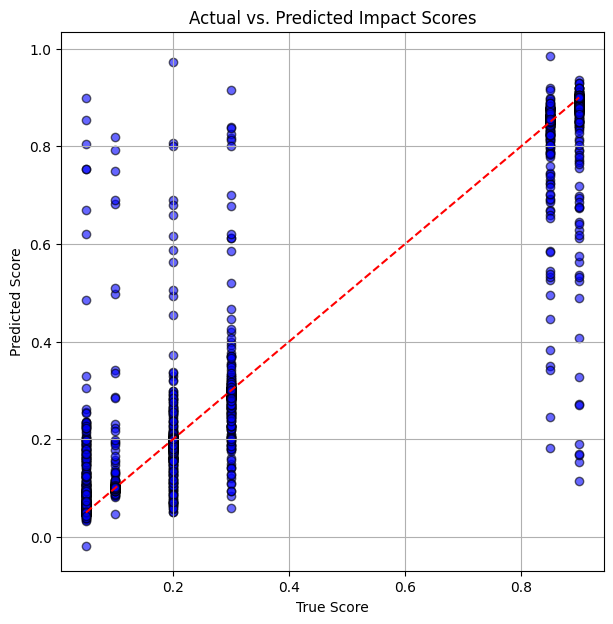

✅ Plot saved to: results/XGBoost/regression_scatter_plot.png


In [62]:
plot_regression_predictions(y_val, y_pred, results_dir)

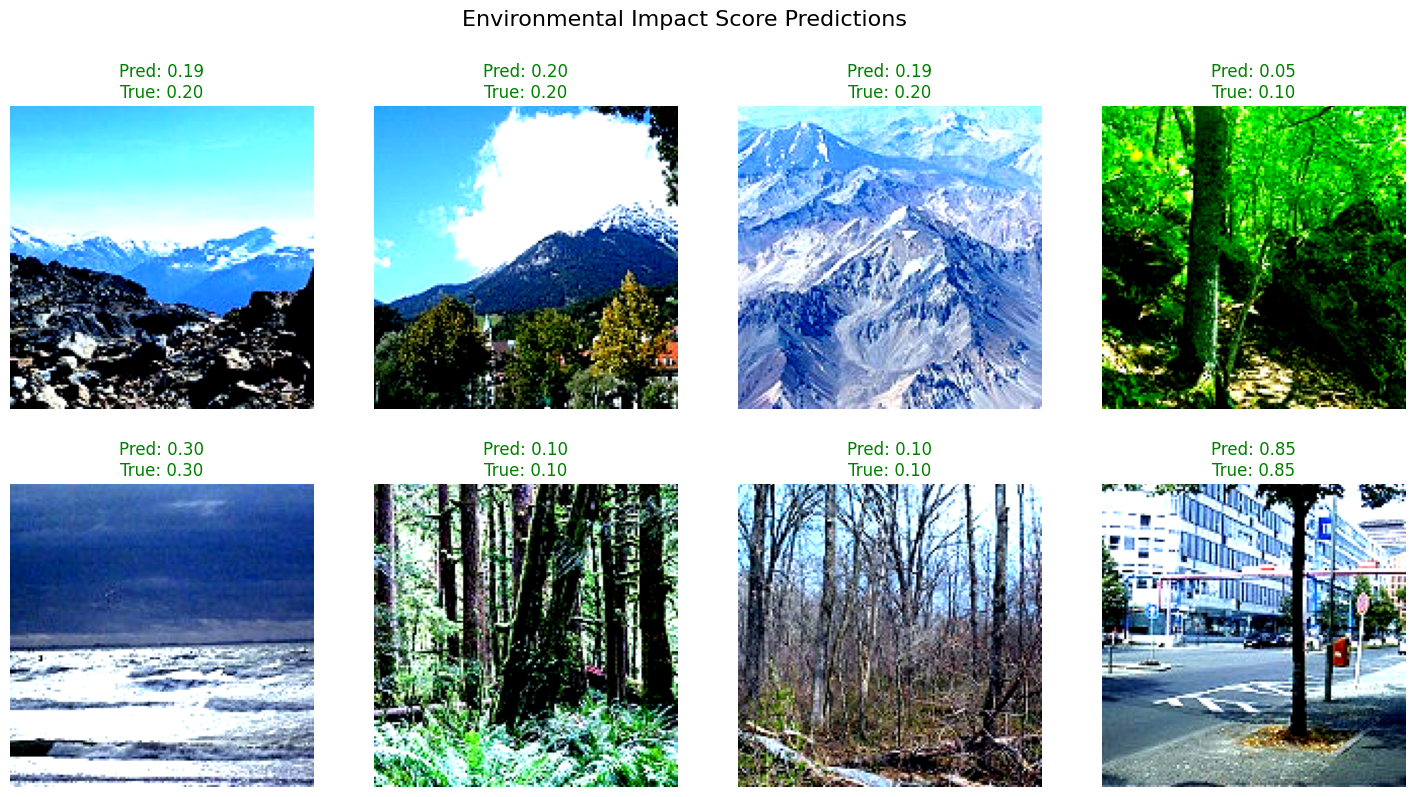

✅ Image predictions saved to: results/XGBoost/regression_image_predictions.png


In [63]:
show_regression_predictions(
    regressor, dataloader, cnn_model, device,
    results_dir, class_names, impact_scores_map, num_images=8
)

In [64]:
# 📌 11: Download Results
files.download('results/XGBoost/env_impact_score_predictor_xgboost.json')
files.download("results/XGBoost/regression_report.txt")
files.download("results/XGBoost/regression_scatter_plot.png")
files.download("results/XGBoost/regression_image_predictions.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>